# Intelligente systemer: Q-læring
Velkommen til denne notebooken som inngår i Høyskolen Kristianias emne «Utvikling og anvendelse av intelligente systemer», modul 6, «Forsterkende læring».

## Hvordan du bruker denne notebooken 
Dette er en Jupyter notebook med tekst og Python-kode som du kjører ved å trykke shift-enter. Hensikten er å bli kjent med relevante konsepter i praksis, ikke nødvendigvis å forstå alle detaljer i koden. Ta deg god tid til å lese teksten, se gjennom koden, kjøre kodecellene (pass på riktig rekkefølge), studere resultatene, og tenke gjennom hva vi gjør, hvorfor og hvordan.

Underveis i teksten vil du finne referanser til Canvas-oppgaver _i kursiv_. Gå til Canvas og besvar spørsmålene der før du går videre i notebooken.

## Problemstilling: Autonom robot til fiolinfabrikk
Vi skal konstruere en autonom robot til en fiolinfabrikk. I fabrikken skal roboter bringe riktige deler til  fiolinmakerne, i riktig rekkefølge. Delene er plassert på 9 ulike lagerplasser, kalt L1–L9. Disse er vist i figuren under. L6 har en spesiell rolle: Det er her fiolinkroppene oppbevares, og det er hit delene skal bringes.

Vi skal prøve oss på en enkel Q-læringsmodell hvor verdien av hver tilstand og handling beskrives i en tabell. Dermed er ikke dette dyp læring. Hvis vi skulle ha brukt dyp læring, måtte vi ha erstattet tabellen med et nevralt nettverk og oppdatert det hver gang det ble samlet inn ny erfaring.

Eksemplet i denne notebooken ligger tett opp til denne bloggen: https://blog.floydhub.com/an-introduction-to-q-learning-reinforcement-learning/

![Environment. Figure from Sayak Paul at blog.floydhub.com](./figures/environment.png)

Oppgaven er å trene roboten (agenten) til å finne den korteste ruten mellom alle lokasjoner på lageret (miljøet). Handlingene som roboten kan utføre, er å bevege seg direkte til ikke-blokkerte nabo-lagerplasser. Det er ikke et fast antall mulige handlinger fra hver tilstand: Fra L4 kan roboten kun velge å gå til L7, mens den fra L7 kan velge å gå til enten L4 eller L8.

_Oppgave: Svar på flervalgsspørsmål 1 (vist nedenfor) i Canvas._

1. _Hva er den korteste lovlige ruten fra L9 til L6?_

## Oppsett

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define the states as numbers for convenience later
location_to_state = {
    'L1' : 0,
    'L2' : 1,
    'L3' : 2,
    'L4' : 3,
    'L5' : 4,
    'L6' : 5,
    'L7' : 6,
    'L8' : 7,
    'L9' : 8}

In [3]:
# Define the actions as the location to go to
actions = [0,1,2,3,4,5,6,7,8]

Det gis belønning til roboten når tilstanden den befinner seg i er direkte forbundet med destinasjons-tilstanden. Det vil si at hvis den står på L8, gis det belønning hvis destinasjonen er L9, men ikke hvis destinasjonen er L6.

In [4]:
# Define the rewards
rewards = np.array([[0,1,0,0,0,0,0,0,0],
                    [1,0,1,0,1,0,0,0,0],
                    [0,1,0,0,0,1,0,0,0],
                    [0,0,0,0,0,0,1,0,0],
                    [0,1,0,0,0,0,0,1,0],
                    [0,0,1,0,0,0,0,0,0],
                    [0,0,0,1,0,0,0,1,0],
                    [0,0,0,0,1,0,1,0,1],
                    [0,0,0,0,0,0,0,1,0]])

In [7]:
rewards

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0]])

Her er det faktisk ingen fysisk barriere i systemet, MEN roboten oppfordres til å nedprioritere ferdsel mellom visse plasser fordi den ikke får belønning.

_Oppgave: Svar på flervalgsspørsmål 2 (vist nedenfor) i Canvas._

2. _Roboten får kun belønning hvis den ikke krysser en sperret rute. Hvordan kan man gjøre slike hindringer enda tydeligere for roboten i dette oppsettet?_

In [8]:
# Initialize parameters
gamma = 0.75 # Discount factor 
alpha = 0.9 # Learning rate 
# Initializing Q-Values
Q = np.array(np.zeros([9,9]))
#iterations = 3
iterations = 100

_Oppgave: Svar på flervalgsspørsmål 3 (vist nedenfor) i Canvas._

3. _Hva betyr diskonteringsfaktoren?_

## Kode for å løse problemet

For å forenkle treningsprosessen og kunne eksperimentere litt, lager vi en klasse kalt `QAgent()`. Klassen består av: 

- **\_\_init__**: Her initialiseres klassen med miljø, handlinger og belønninger. Nødvendig input er: 

    - **gamma**: Diskonteringsfaktoren i Bellmans ligning. 
    - **alpha**: Læringsraten i Bellmans ligning. 
    - **location_to_state**: Dictionary som oversetter mellom tilstand og indeksnummer for tilstanden. 
    - **actions**: Array av mulige handlinger. 
    - **rewards**: 2D-array med belønninger som angir hvilke lokasjoner som er 'direkte' forbundet. 
    - **state_to_location**: Dictionary som oversetter mellom indeksnummer for tilstanden og navnet. 
    - **Q**: Q-verdier. Enten et tomt array eller en pre-trent modell. 


- **training**: Funksjon som trener roboten. Den tar som input: 
    - **start_location**: Start-lokasjon. 
    - **end_location**: Mål-lokasjon. 
    - **iterations**: Antall ganger modellen skal forsøke å forbedre seg. 

    For å kommunisere til roboten at det er mål-tilstanden vi ønsker å oppnå, er første steg i treningen å øke verdien til belønningen på nettopp målposisjonen. For hver iterasjon velger algoritmen et tilfeldig startsted og lister de gyldige handlingene. Roboten utforsker en tilfeldig handling fra startstedet, før den beregner belønning og Q-verdi av handlingen og oppdaterer Q-tabellen. Til slutt kaller den `get_optimal_route`, som bruker Q-tabellen til å angi ruten med høyest forventet belønning.
    
- **get_optimal_route**: Funksjon som gir roboten den optimale ruten mellom to lokasjoner basert på grådig utnyttelse av Q-tabellen. Det vil si at roboten alltid skal bevege seg mot høyere Q-verdi. 

In [9]:
class QAgent():
    
    # Initialize alpha, gamma, states, actions, rewards, and Q-values
    def __init__(self, alpha, gamma, location_to_state, actions, rewards, Q):
        
        self.gamma = gamma  
        self.alpha = alpha 
        
        self.location_to_state = location_to_state
        self.actions = actions
        self.rewards = rewards
        # Inverse mapping of indices to locations
        self.state_to_location = dict((state,location) 
            for location,state in location_to_state.items())
        self.Q = Q
        
    # Training the robot in the environment
    def training(self, start_location, end_location, iterations, verbose=False):
        
        rewards_new = np.copy(self.rewards)
        
        ending_state = self.location_to_state[end_location]
        rewards_new[ending_state, ending_state] = 999   # Communicate to robot that end state is special
        
        for i in range(iterations):
            current_state = np.random.choice(list(location_to_state.values()))  # Randomly sample starting point
            playable_actions = []

            # Iterate through the new rewards matrix and get the actions > 0
            for j in range(9):
                if rewards_new[current_state,j] > 0:
                    playable_actions.append(j)  # possible actions from starting location
    
            next_state = np.random.choice(playable_actions)  # pick random action among those possible
            TD = rewards_new[current_state, next_state] + \
                    self.gamma * self.Q[next_state, np.argmax(self.Q[next_state,:])] \
                        - self.Q[current_state, next_state]  # Bellman's equation for the Q-value
            # update Q-table with best value multiplied by learning rate
            self.Q[current_state, next_state] += self.alpha * TD  

            if verbose==True:
                print(f'Iteration {i}: {current_state} to {ending_state}, next state {next_state}, current Q={TD}')

        # Initialize the optimal route with the starting location
        route = [start_location]
        # We do not know the next move of the robot, so we set the next location to the starting location
        next_location = start_location

        sns.heatmap(self.Q)
        plt.title("Q-table", fontsize=10)
        plt.show()

        # Get the route 
        self.get_optimal_route(start_location, end_location, next_location, route, self.Q)
        
    # Get the optimal route
    def get_optimal_route(self, start_location, end_location, next_location, route, Q):
        
        while(next_location != end_location):
            starting_state = self.location_to_state[start_location]
            # The possible action with the highest immediate and future expected 
            # reward is given by the maximal Q-value
            next_state = np.argmax(Q[starting_state,])  
            next_location = self.state_to_location[next_state]
            route.append(next_location)
            start_location = next_location

            if len(route) > rewards.size:
                print('Q-matrix too little explored, increase number of iterations')
                break
        
        print(route)

Iteration 0: 1 to 5, next state 2, current Q=1.0
Iteration 1: 3 to 5, next state 6, current Q=1.0
Iteration 2: 6 to 5, next state 7, current Q=1.0
Iteration 3: 1 to 5, next state 4, current Q=1.0
Iteration 4: 8 to 5, next state 7, current Q=1.0
Iteration 5: 6 to 5, next state 7, current Q=0.09999999999999998
Iteration 6: 5 to 5, next state 5, current Q=999.0
Iteration 7: 4 to 5, next state 1, current Q=1.675
Iteration 8: 7 to 5, next state 8, current Q=1.675
Iteration 9: 1 to 5, next state 2, current Q=0.09999999999999998
Iteration 10: 0 to 5, next state 1, current Q=1.7425
Iteration 11: 7 to 5, next state 6, current Q=1.7425
Iteration 12: 4 to 5, next state 1, current Q=0.23499999999999988
Iteration 13: 0 to 5, next state 1, current Q=0.17425000000000002
Iteration 14: 3 to 5, next state 6, current Q=0.8424999999999999
Iteration 15: 3 to 5, next state 6, current Q=0.08424999999999994
Iteration 16: 4 to 5, next state 1, current Q=0.023500000000000076
Iteration 17: 6 to 5, next state 3, 

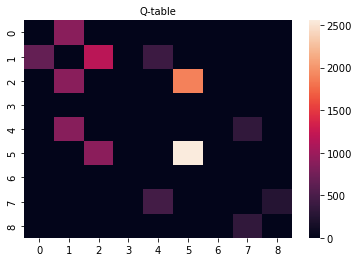

['L9', 'L8', 'L5', 'L2', 'L3', 'L6']


In [49]:
agent = QAgent(alpha, gamma, location_to_state, actions, rewards, Q)
agent.training('L9','L6', iterations, verbose=True)

_Oppgave: Svar på flervalgsspørsmål 4–7 (vist nedenfor) i Canvas._

4. _Hvor mange iterasjoner bør man minimum trene?_
5. _Øk antall iterasjoner til 100. Hva foreslår algoritmen da som den optimale ruten mellom L9 og L6?_
6. _I denne algoritmen utforsker vi tilfeldig. Hvordan kunne vi ha implementert en mer effektiv utforskning?_
7. _Hva må vi gjøre hvis vi ønsker å konvertere algoritmen til dyp forsterkende læring?_

_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 1 (vist nedenfor) i Canvas._

1. _Beskriv kort hva som måtte endres dersom fabrikken kjøpte nabobygget som hadde ytterligere ni lokasjoner._